# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from epiml.loadepiml import LoadEpiml, load_search, save_search
from epiml.epimlsklearn.epimlmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from epiml.semisuperhelper import SemiSupervisedHelper
from epiml.epimlsklearn.pnuwrapper import PNUWrapper
from epiml.epimlsklearn.jsearchcv import JRandomSearchCV, extract_score_grid
from epiml.epimlsklearn.nestedcross import NestedCV, rerun_nested_for_estimator, rerun_nested_for_scoring
from epiml.epimlsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested

In [3]:
path = "C:\Data\membership14_final_0103.txt"
lc = LoadEpiml(path)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

## Set up randomized search parameters

In [6]:
rf_param_search = {
 'base_estimator__bootstrap': [True, False],
 'base_estimator__class_weight': [None,'balanced','balanced_subsample'],
 'base_estimator__criterion': ['gini','entropy'],
 'base_estimator__max_depth': [None] + list(range(2,100)),
 'base_estimator__max_features': ['sqrt','log2',None] + list(range(5,100)),
 'base_estimator__min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100],
 'base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,
                                                        0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
 'base_estimator__n_estimators': sp.stats.randint(low=10, high=500),
 'pu_learning': [True, False],
 'num_unlabeled':sp.stats.randint(low=0, high=15000),
                  }

## Set up PNU Wrapper with Random Forest, then JSearchCV, then NestedCV

In [7]:
pnu = PNUWrapper(base_estimator=RandomForestClassifier(verbose=1), random_state=42)

In [8]:
jsearch = JRandomSearchCV(pnu, rf_param_search, n_iter=100, scoring=FrankenScorer('pu_mix_assumed_f1beta10'),
                                n_jobs=-1, cv=3, random_state=77, verbose=1, pre_dispatch=8)

#### 3x3 (x100) nested cross validation

In [9]:
nested_cross = NestedCV(jsearch, scoring=FrankenScorer('pu_mix_assumed_f1beta10'),
                        cv=3, random_state=77, use_same_random_state=True)

## Score the nested cross - 900 models!

In [10]:
scores = nested_cross.score(X_train.values, y=y_train.values, verbose=1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.1min finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.2s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.9min finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   23.4s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.2s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 48.5min finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   23.1s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 146.4min finished


## The scores of the 3 folds of the outer loop.  FrankenScorer for 100*f1beta=10 + PU

In [11]:
scores

(85.260040741577825, 81.945673649598945, 82.120690063980064)

In [12]:
save_search(nested_cross, './res/nested_cross_rf_large_20170210')

In [13]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0315944
assumed_brier_neg                                                  0.0308076
assumed_f1                                                          0.139275
assumed_f1beta10                                                    0.706634
confusion_matrix_lab       [[252.666666667, 34.6666666667], [128.0, 428.6...
confusion_matrix_un             [[111791.0, 5171.0], [128.0, 428.666666667]]
fn_confusion_matrix_lab                                                  128
fn_confusion_matrix_un                                                   128
fp_confusion_matrix_lab                                              34.6667
fp_confusion_matrix_un                                                  5171
labeled_acc                                                         0.807264
labeled_avg_prec                                                     0.92359
labeled_brier                                                       0.159918

# Let's dive in and see the parameters for one of the best models

In [14]:
all_scores = [extract_score_grid(est) for est in nested_cross.estimators_]

In [15]:
best_clf_idx = [s.mean_pu_mix_assumed_f1beta10_test.idxmax() for s in all_scores]

In [16]:
[est.cv_results_['params'][best_idx] for est, best_idx in zip(nested_cross.estimators_, best_clf_idx)]

[{'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced_subsample',
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 31,
  'base_estimator__max_features': 68,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 298,
  'num_unlabeled': 12743,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced_subsample',
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 31,
  'base_estimator__max_features': 68,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 298,
  'num_unlabeled': 12743,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced_subsample',
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 31,
  'base_estimator__max_features': 68,
  'base_estimator__min_samples_l

## Let's see what feature importance looks like for this specific estimator

In [17]:
all_feature_importances = [est.best_estimator_.feature_importances_ for est in nested_cross.estimators_]
feature_importances = np.mean(all_feature_importances, axis=0)
feature_table = pd.DataFrame(feature_importances, index=X_test.columns).sort_values(by=0, ascending=False)

In [18]:
feature_table

,0
DIAG_FLAG4_Sum,2.638786e-01
DIAG_FLAG5_Sum,1.513481e-01
ndc_cat58_Sum,4.908978e-02
age,2.722900e-02
CPT_FLAG9_Sum,2.316328e-02
ndc_cat87_Sum,2.175923e-02
DIAG_FLAG75_Sum,2.034211e-02
ndc_cat54_Sum,1.526256e-02
CPT_FLAG43_Sum,1.417151e-02
CPT_FLAG48_Sum,1.353735e-02


## Let's see what happens when use assumed_fbeta10 instead

In [19]:
nested_cross, new_estimators = rerun_nested_for_scoring(nested_cross, 'assumed_f1beta10', X=X_train.values, y=y_train.values,
                                        how='max', n_jobs=-1, verbose=1, return_estimators=True)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.7s finished


In [20]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0594606
assumed_brier_neg                                                  0.0590956
assumed_f1                                                          0.100832
assumed_f1beta10                                                     0.71286
confusion_matrix_lab       [[244.666666667, 42.6666666667], [104.33333333...
confusion_matrix_un        [[108994.333333, 7967.66666667], [104.33333333...
fn_confusion_matrix_lab                                              104.333
fn_confusion_matrix_un                                               104.333
fp_confusion_matrix_lab                                              42.6667
fp_confusion_matrix_un                                               7967.67
labeled_acc                                                         0.825832
labeled_avg_prec                                                    0.925062
labeled_brier                                                        0.13965

In [21]:
all_scores = [extract_score_grid(est) for est in nested_cross.estimators_]

In [22]:
best_clf_idx = [s.mean_assumed_f1beta10_test.idxmax() for s in all_scores]

In [23]:
[est.cv_results_['params'][best_idx] for est, best_idx in zip(nested_cross.estimators_, best_clf_idx)]

[{'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced',
  'base_estimator__criterion': 'gini',
  'base_estimator__max_depth': 45,
  'base_estimator__max_features': 81,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 0.005,
  'base_estimator__n_estimators': 86,
  'num_unlabeled': 6377,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced',
  'base_estimator__criterion': 'gini',
  'base_estimator__max_depth': 45,
  'base_estimator__max_features': 81,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 0.005,
  'base_estimator__n_estimators': 86,
  'num_unlabeled': 6377,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced',
  'base_estimator__criterion': 'gini',
  'base_estimator__max_depth': 45,
  'base_estimator__max_features': 81,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_sam

In [24]:
all_feature_importances = [est.feature_importances_ for est in new_estimators]
feature_importances = np.mean(all_feature_importances, axis=0)
feature_table = pd.DataFrame(feature_importances, index=X_test.columns).sort_values(by=0, ascending=False)

In [25]:
feature_table

,0
DIAG_FLAG4_Sum,0.368265
DIAG_FLAG5_Sum,0.198118
ndc_cat58_Sum,0.056877
CPT_FLAG9_Sum,0.028110
DIAG_FLAG75_Sum,0.025910
ndc_cat87_Sum,0.019252
age,0.015938
DIAG_FLAG6_Sum,0.011140
ndc_cat54_Sum,0.010488
CPT_FLAG43_Sum,0.009629


## Lets see what unlabeled probability histogram looks like

In [26]:
probabs = nested_cross.estimators_[0].predict_proba(X_test.values)[:, 1]

[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    3.9s finished


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000FF73940>]], dtype=object)

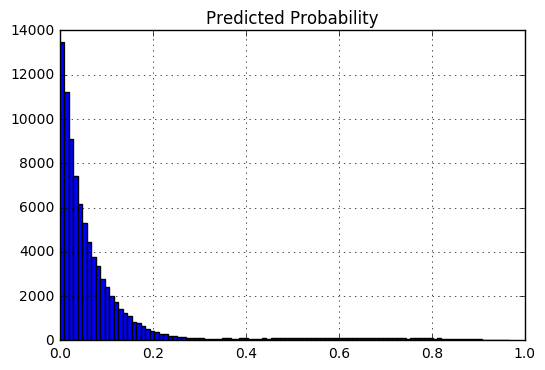

In [27]:
pd.DataFrame(probabs, columns=['Predicted Probability']).hist(bins=100)

In [28]:
new_probabs = new_estimators[0].predict_proba(X_test.values)[:, 1]

[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    1.0s finished


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000102794A8>]], dtype=object)

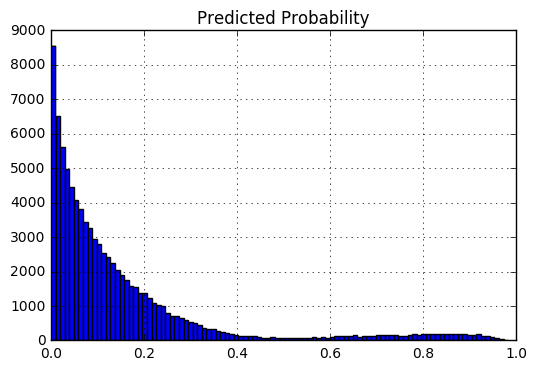

In [29]:
pd.DataFrame(new_probabs, columns=['Predicted Probability']).hist(bins=100)